# Training a Reverse Denoising Model 

## Introduction

Now that we've analyzed the forward diffusion process and compared different loss functions,
let's now take a look at applying these ideas in training an actual denoising model.
By the end of this notebook, we should hopefully have a model that is able to do some kind of denoising
on our inputs to see if we can generate new samples - let's see how we do!

<img src="diagrams/training.png" width="700">
<img src="diagrams/sampling.png" width="700">

Figure 1 (left) shows the training procedure where the output from the forward diffusion process is taken as the input by a deep neural net. Parameters $\theta$ of the deep neural net are updated to produce a predicted distribution $p_\theta$.

Figure 2 (right) shows how the states are sampled from the predicted distribution during the reverse denoising process. 

We will implement the processes illustrated by the above two figures. 

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from typing import List, Tuple
from tqdm import tqdm
import itertools

In [2]:
import jax.numpy as jnp
from jax import value_and_grad, jit, vmap, random
from jax import Array
from jax.config import config
config.update("jax_debug_nans", True)
config.update("jax_array", True)

## Building the model

We first build the denoising model by initializing a U-Net style linear model.
Usually, a U-Net model consists of a contracting path and an expansive path,
where the input gets downsampled to smaller dimensions, and then upsampled back to its original dimensions,
along with residual connections from the downsampling portion to the upsampling portion.

In our case here though, our inputs will be very small: 3 x 3 images to produce
inputs of flattened dimension 9.
If we were to downsample even further, we may not have enough expressiveness
in our model for our purposes.

Thus, we'll be adopting an upside-down U-shape structure to build the denoising model.
In other words, we'll first upsample the input to larger dimensions,
and then downsample back to the size of the original image.
This allows us to have more expressiveness due to the much larger amount of parameters available.

The following functions set up uniformly random initialization for each layer of the model
as well as the entire model itself, which takes in a list of sizes for the dimensions of each of the layers.

In [3]:
def init_layer(key, in_dims: List[int], out_dim: int) -> List[Array]:
    """
    Initialize weight and bias terms for a layer that takes in inputs with
    dimensions in_dims and then outputs values with dimension out_dim.

    in_dims: dimensions of the input, i.e. in_dim[0] x 1, in_dim[1] x 1, ...
    out_dim: dimension of the output, i.e. out_dim x 1

    Return the weight matrices and bias vector for the layer.

    weight: out_dim x in_dim[0], out_dim x in_dim[1], ...
    bias: out_dim x 1
    """
    b_key, *w_keys = random.split(key, num=len(in_dims) + 1)
    weights = []
    for w_key, in_dim in zip(w_keys, in_dims):
        bound = jnp.sqrt(1 / in_dim)
        weight = random.uniform(w_key, (out_dim, in_dim), minval=-bound, maxval=bound)
        weights.append(weight)
    bias = random.uniform(b_key, (out_dim,), minval=-bound, maxval=bound)
    return weights + [bias]


def init_unet(key, sizes: List[int]) -> List[List[Array]]:
    """
    Initialize a U-Net style linear model with layer input and output
    dimensions from sizes. When sizes is of length N, the resulting model
    will contain 2 * (N-1) + 1 layers.

    key: random.PRNGKey(seed), used for randomness in initialization.
    sizes: list of integers to be used for layer dimension sizes.

    Return a list of layer parameters, where each layer is described as a
    list of the form: (weight, bias) for layers 1 through N and
    (prev_weight, res_weight, bias) for layers (N+1) through (2N-1).
    """
    n = len(sizes)
    key, *layer_keys = random.split(key, num=2 * n)

    model = []
    for i in jnp.arange(n - 1):
        # (weight, bias)
        layer = init_layer(layer_keys[i], [sizes[i]], sizes[i + 1])
        model.append(layer)

    # (weight, bias)
    layer = init_layer(layer_keys[n - 1], [sizes[n - 1]], sizes[n - 1])
    model.append(layer)

    for i in jnp.flip(jnp.arange(1, n)):
        # (prev_weight, res_weight, bias)
        layer = init_layer(
            layer_keys[n + i - 1], [sizes[i], sizes[i - 1]], sizes[i - 1]
        )
        model.append(layer)

    return model


Now try creating a U-Net style model that takes the form:

```
Layer 0:
	W0: (6, 9)
	b : (6,)
Layer 1:
	W0: (4, 6)
	b : (4,)
Layer 2:
	W0: (4, 4)
	b : (4,)
Layer 3:
	W0: (6, 4)
	W1: (6, 6)
	b : (6,)
Layer 4:
	W0: (9, 6)
	W1: (9, 9)
	b : (9,)
```

where `W0` represents the weight matrix that affects the output of the previous layer,
`W1` represents the weight matrix for the residual connection from the correspondingly sized layer,
and `b` represents the bias for the layer.

**You should pass in the `model_key` and a list of sizes to `init_unet`, and the output of the next cell should look like the description above.**

**Hint**:
It may help to read *carefully* through the docstring for `init_unet`,
as it describes how many layers to expect when you pass in a list of sizes
of length `N`.

In [4]:
model_key = random.PRNGKey(0)
# BEGIN SOLUTION
model = init_unet(model_key, [9, 6, 4])
# END SOLUTION
for i, layer in enumerate(model):
    print(f"Layer {i}:")
    for j, weight in enumerate(layer[:-1]):
        print(f"\tW{j}: {weight.shape}")
    bias = layer[-1]
    print(f"\tb : {bias.shape}")

Layer 0:
	W0: (6, 9)
	b : (6,)
Layer 1:
	W0: (4, 6)
	b : (4,)
Layer 2:
	W0: (4, 4)
	b : (4,)
Layer 3:
	W0: (6, 4)
	W1: (6, 6)
	b : (6,)
Layer 4:
	W0: (9, 6)
	W1: (9, 9)
	b : (9,)


So far, we've only initialized the parameters of a model.
How about the activations?

Run the following cell to define `sigmoid` and `relu`,
which we'll be using for predictions later.

In [5]:
@jit
def sigmoid(x: Array) -> Array:
    """
    Compute the element-wise sigmoid of x.
    """
    return 0.5 * (jnp.tanh(x / 2) + 1)


@jit
def relu(x: Array) -> Array:
    """
    Compute the element-wise RELU of x.
    """
    return jnp.maximum(0, x)

The U-Net model aims to denoise the state at each timestep as a way to approximate the forward denoising process distribution. 

In the following cell, we'll be defining how the `model` will actually `predict` the noise given `x` and `t`. 
**Choose either `relu` or `sigmoid` for the `activation` function that will be used in the model's prediction.**

Don't worry if you're not sure which one will be more performant,
as you can always come back and change it to the other activation function
if you'd like to compare their results from training.

(Note that for our model, we'll be appending `t` to the end of the flattened state `x` as the input to our network.
This is to allow the model to also account for the effects of `t` on its prediction of the noise.
At the end of the `predict` function, since we expect the output to be of the same shape as `x`,
we'll truncate the output, for ease of implementation.
Since we'll be running losses through these outputs later,
they should learn to move towards the output we expect.)


In [6]:
@jit
def predict(model: List[List[Array]], x: Array, t: int) -> Array:
    """
    Return the prediction of the U-Net model for given inputs x and t.

    model: model used for predicting
    x: state at time t
    t: number of timesteps
    """
    # BEGIN SOLUTION
    activation = relu
    # alternatively:
    # activation = sigmoid
    # END SOLUTION

    n = len(model)
    mid = n // 2
    xt = jnp.append(x, t)

    res_xt = []
    for i in range(0, mid):
        res_xt.append(xt)
        weight, bias = model[i]
        xt = activation(jnp.dot(weight, xt) + bias)

    weight, bias = model[mid]
    xt = activation(jnp.dot(weight, xt) + bias)

    for i in range(mid + 1, n):
        prev_weight, res_weight, bias = model[i]
        xt = jnp.dot(prev_weight, xt) + jnp.dot(res_weight, res_xt.pop()) + bias
        if i < n - 1:
            xt = activation(xt)

    return xt[:-1]


## Training the model

The following diagram shows the training process where the output from the forward diffusion process is taken as the input by the deep neural net with parameters $\theta$.

To obtain an accurate predicted distribution $p_\theta$ for approximating the forward diffusion process distribution $q$, we can train any combination of models that predict the mean $\mu_\theta$, the covariance $\Sigma_\theta$, and the noise $\epsilon$.

The training loss of the prediction and target is computed to update the neural net parameters. 

<img src="diagrams/training.png" width="1000">


So far, we've defined what we need for initializing and then running the model to get predictions.

Before we start training, we'll need to define the loss function we'll be using.
For our model, we make the design choice to have the variance of the predicted distribution
be set to the same variances as were defined in the variance schedule.
Thus, the loss can therefore be simplified to look at either the mean or the noise,
in the form of an MSE loss.

Here we also provide the forward diffusion function that you derived in question 1.
This function computes the noisy state $x_t$
given initial starting state $x_0$, variance schedule ($\beta_t$'s),
and randomly sampled Gaussian noise $\epsilon$ to be added to the initial starting state.

Both of these functions will be used in our training loop: the loss to run gradients over,
and the forward diffusion process to compute $x_t$ to pass into our model.

In [7]:
@jit
def mse_loss(output: Array, target: Array) -> Array:
    """
    Return the MSE (Mean Squared Error) loss between the target and output.
    """
    D = jnp.prod(jnp.array(target.shape))
    error = target - output
    return jnp.sum((error).dot(error)) / D


@jit
def forward_diffuse(x_init: Array, t: int, var_schedule: Array, noise: Array) -> Array:
    """
    Compute x from the initial starting state, the given variance schedule,
    and the randomly sampled Gaussian noise.

    x_init: initial state
    t: number of timesteps to run forward diffusion for
    var_schedule: variance schedule of length t (timesteps)
    noise: randomly sampled Gaussian noise for diffusing x_init

    Return value:
    x: state after diffusing x_init for t timesteps
    """
    alpha = jnp.cumprod(var_schedule)[t]
    return jnp.sqrt(alpha) * x_init + jnp.sqrt(1 - alpha) * noise


To speed up training, we can vectorize the functions we'll be using to
run them on batches of inputs at a time. This is accomplished using JAX's
`vmap` function (aka "vectorizing map`).

In [8]:
# vectorize these functions to be able to run batches of inputs
batched_predict = vmap(predict, in_axes=(None, 0, 0))
batched_mse_loss = vmap(mse_loss, in_axes=(0, 0))
batched_forward_diffuse = vmap(forward_diffuse, in_axes=(0, 0, None, 0))

What loss function we choose plays a large role in determining what and how our model will learn,
and above we defined MSE as the loss we'll be using.

But what are we taking the MSE *of* - what do we want the model to actually *learn*?

For this implementation,
we'll be training on an MSE loss that **compares the actual noise** (added to $x_0$
to diffuse to $x_t$) **to the predicted noise from our model.**

(You can see in at the end of the `training_loss` function where we're comparing
the `output_noise` (from our model) and the `noise` (actual noise used in the forward process)
in our `mse_loss` that we defined above.)

Since training can take a while when unoptimized,
we've also added the `@jit` decorator that `jax`
provides to hopefully speed things up a bit -
those with deadlines don't always have the chance to be patient after all!

In [9]:
@jit
def training_loss(
    key,
    model: List[List[Array]],
    x_init: Array,
    var_schedule: Array,
) -> Array:
    """
    Compute x(t) for every input in the batched x_init, predict the noise,
    and return the mean of the loss between predicted and target noise.

    key: random.PRNGKey used for seeding randomness
    model: parameters of the model to be trained
    x_init: batched inputs
    var_schedule: variance schedule
    """
    batch_size, n = x_init.shape
    t_key, noise_key = random.split(key, num=2)

    t = random.uniform(
        t_key, shape=(batch_size, 1), minval=0, maxval=len(var_schedule)
    ).astype(int)
    noise = random.multivariate_normal(
        noise_key, jnp.zeros(n), jnp.eye(n), shape=(batch_size,)
    )

    x = batched_forward_diffuse(x_init, t, var_schedule, noise)
    output_noise = batched_predict(model, x, t)
    return jnp.mean(batched_mse_loss(output_noise, noise))


@jit
def update(
    key,
    model: List[List[Array]],
    x_init: Array,
    var_schedule: Array,
    step_size: float,
) -> Tuple[Array, List[List[Array]]]:
    """
    Compute gradient update and return the loss and the updated model.

    key: random.PRNGKey used for seeding randomness
    model: parameters of the model to be trained
    x_init: batched_inputs
    var_schedule: variance schedule
    step_size: step size of gradient step
    """
    loss, grads = value_and_grad(training_loss, argnums=1)(
        key, model, x_init, var_schedule
    )

    updated_model = []
    for parameters, gradients in zip(model, grads):
        layer = []
        for parameter, gradient in zip(parameters, gradients):
            layer.append(parameter - step_size * gradient)
        updated_model.append(layer)

    return loss, updated_model


Here we define the dimensions of our input as well as the variance schedule we'll be working with.

In [10]:
# define input characteristics
input_shape = (3, 3)
input_dim = int(jnp.prod(jnp.array(input_shape)))
var_schedule = jnp.flip(jnp.array([0.1 * i for i in range(1, 5)]))
print(var_schedule)

[0.4 0.3 0.2 0.1]


For our training data, we'll have the same input each time:
a single dot in the middle of a 3 x 3 image.

Even though we're passing in the same input, we'll still end up with different
and interesting results during each training loop due to the randomness that
gets applied when both choosing `t` (the number of timesteps to run diffusion
on in the input for) as well as when applying Gaussian noise to each input in
the diffusion process.

In [11]:
# number of samples
n = 100 

data = jnp.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]).flatten()
training_data = jnp.repeat(jnp.array([data]), n, axis=0)

print(training_data.shape)
print()
print(f"Example input:\n{data.reshape(input_shape)}")

(100, 9)

Example input:
[[0 0 0]
 [0 1 0]
 [0 0 0]]


Here we initialize the model that we will be training and
set some hyperparameters for the training loop.
`step_sizes` here refers to our learning rate over the number of epochs.

Note: The input dimension of the model is actually `input_dim + 1` instead of
just `input_dim` to account for passing in the number of timesteps `t` as an
additional input. See the `predict` model if you'd like a refresher on how that
works!

In [12]:
# initialize model
model_key = random.PRNGKey(1)
model = init_unet(model_key, [input_dim + 1, 200, 1000])

# hyperparameters to be changed
step_sizes = [1.7, 1.5, 1.3]
total_epochs = 3000

Finally, we're ready to train our denoising model.
**Run the cell below to start training!**

The training process should be done within a few minutes (hopefully).
The current epoch loss will also be shown to the right of the progress bar
if you'd like to see live updates of how the loss evolves as our model
improves over time.

In [13]:
training_key = random.PRNGKey(2)

# calculated values
keys = random.split(training_key, num=total_epochs)
epoch_progress = tqdm(
    list(itertools.product(step_sizes, range(total_epochs // len(step_sizes))))
)

epoch_losses = []
for subkey, (step_size, _) in zip(keys, epoch_progress):
    x = training_data
    loss, model = update(subkey, model, x, var_schedule, step_size)

    # update tqdm progress bar with current loss
    epoch_progress.set_postfix_str(f"Loss {loss}")
    epoch_losses.append(loss)

trained_model = model


100%|█████████▉| 2999/3000 [00:26<00:00, 113.73it/s, Loss 0.0002147861523553729] 


Minimum epoch_loss found: 0.00015757196524646133
Last loss found: 0.0002147861523553729


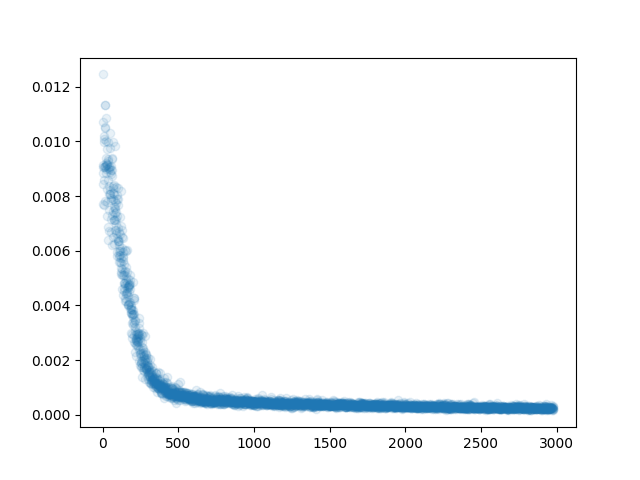

In [14]:
print(f"Minimum epoch_loss found: {jnp.min(jnp.array(epoch_losses))}")
print(f"Last loss found: {epoch_losses[-1]}")

for _ in range(20):
    # Close any prior plots
    plt.close()

plt.scatter(range(len(epoch_losses[20:])), epoch_losses[20:], alpha=0.1)
plt.show()

## Generating Samples

The following figure shows how to sample the predicted states for each timestep, based on the predicted reverse process distribution that our model learned in the previous section.

For generation, we sample $\hat{x}_t$ from the standard normal distribution. Otherwise, when taking $x_t$ from the forward process as our $\hat{x}_t$, we can consider reconstructing $x_{t-1}$, i.e. running the denoising process for a single timestep.

Once we have $\hat{x}_t$, we can then use our trained deep neural net to sample the next state $\hat{x}_{t-1}$ from our predicted distribution $p_\theta(\hat{x}_{t-1}|\hat{x}_t)$.
Repeating this process for some number of timesteps gives us a prediction for $\hat{x}_0$, which is a generated sample using our model.

We can then compare this result with the original input to visualize the denoising process.

<img src="diagrams/sampling.png" width="1000">

Now that we have obtained a model that is able to predict noise,
we can use it in our reverse denoising process.

We'll consider two main uses in the following code blocks:

1. Starting from i.i.d randomly sampled Gaussian noise, generating a new sample
   from the original interesting distribution that our model has hopefully
   learned. (Since our only input was a single dot, we expect to generate a
   sample that also looks like a single dot.)
2. Taking some training data $x_{0}$, running the forward process for a *single*
   timestep to obtain $x_{1}$ from $x_{0}$. Let's see if we're able to obtain some
   reproduction $\hat{x}_{0}$ similar to the training data input as a result of denoising.

Though the main goal of our model is generation,
we also consider reconstruction over a *single* timestep as a way of seeing
whether the model has successfully learned how to denoise from $x_{t}$ to
$x_{t-1}$ (which was the goal of the training loss above).

In [15]:
@jit
def reverse_diffuse(x: Array, t: int, var_schedule: Array, noise: Array) -> Array:
    """
    Compute x(t-1) from x(t) (the state at t), the given variance schedule,
    and the predicted noise.

    x: state after diffusing x_init for t timesteps
    var_schedule: variance schedule of length t (timesteps)
    noise: predicted noise

    Return value:
    x(t-1): (predicted) previous state
    """
    alpha = jnp.cumprod(var_schedule)[t]
    beta = var_schedule[t]
    return (x - beta * noise / jnp.sqrt(1 - alpha)) / jnp.sqrt(1 - beta)


@jit
def generate(
    key, x_init: Array, var_schedule: Array, model: List[List[Array]]
) -> Array:
    x = x_init
    subkeys = random.split(key, num=len(var_schedule) - 1)
    for key, t in zip(subkeys, jnp.flip(jnp.arange(1, len(var_schedule)))):
        # predict noise for denoising
        noise = predict(model, x, t)
        # reverse diffuse one step
        x = reverse_diffuse(x, t, var_schedule, noise)
        # sample Gaussian noise for adding more variance
        z = random.multivariate_normal(key, jnp.zeros(input_dim), jnp.eye(input_dim))
        # add sampled Gaussian noise to x
        x = x + jnp.sqrt(var_schedule[t]) * z

    # x(1) -> x(0) with no additional Gaussian noise
    noise = predict(model, x, 0)
    return reverse_diffuse(x, 0, var_schedule, noise)


We'll again vectorize the functions to enable batch processing and speed things up a bit.

In [16]:
batched_reshape = vmap(jit(lambda x: x.reshape(input_shape)))
batched_generate = vmap(generate, in_axes=(0, 0, None, None))

In [17]:
from utils import show_plots

We'll consider two inputs:

1. `x_init_noise`: i.i.d. randomly sampled Gaussian noise for generation.
2. `x_init_diffused`: training data that was forward diffused for *one* timestep.

In [18]:
num_samples = 5

# sample x(t) states to pass into the generator
x_key = random.PRNGKey(19)
x_init_noise = random.multivariate_normal(
    x_key, jnp.zeros(input_dim), jnp.eye(input_dim), shape=(num_samples,)
)
x_init_diffused = batched_forward_diffuse(
    training_data[:num_samples],
    jnp.repeat(1, num_samples),
    var_schedule[:1],
    x_init_noise,
)

With these inputs, we can now run the denoising process by running `generate`:

1. `x_from_noise`: generating new samples from noise.
2. `x_from_diffused`: reconstructing the original samples from their one-step diffused states.

In [19]:
# Let timesteps < length of the variance schedule var_schedule
# and represent how many timesteps we want to run the reverse denoising process
# for the goal of generation, e.g. x_from_noise.
# BEGIN SOLUTION
timesteps = 4
# END SOLUTION

In [20]:
generate_key = random.PRNGKey(20)
subkeys = random.split(generate_key, num=num_samples)

x_from_noise = batched_generate(
    subkeys, x_init_noise, var_schedule[:timesteps], trained_model
)
x_from_diffused = batched_generate(
    subkeys, x_init_diffused, var_schedule[:1], trained_model
)

Run the following cell to visualize the initial random noise we started with
in the first figure, and then the new samples we generated in the second figure.

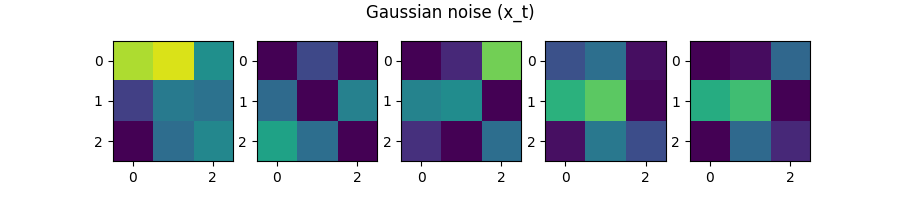

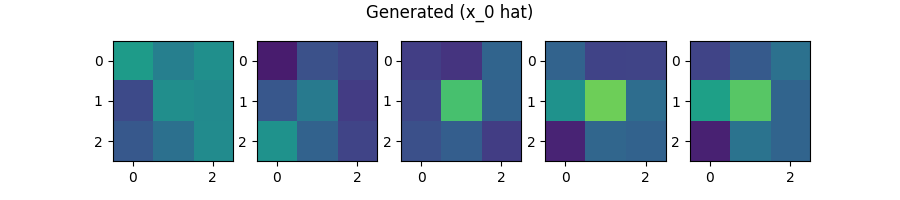

In [21]:
show_plots(batched_reshape(x_init_noise), True, "Gaussian noise (x_t)")
show_plots(batched_reshape(x_from_noise), True, "Generated (x_0 hat)")

Run the next call to visualize the initial inputs $x_0$,
then their one-step diffused versions $x_1$,
and finally the reconstructed versions $\hat{x}_0$.

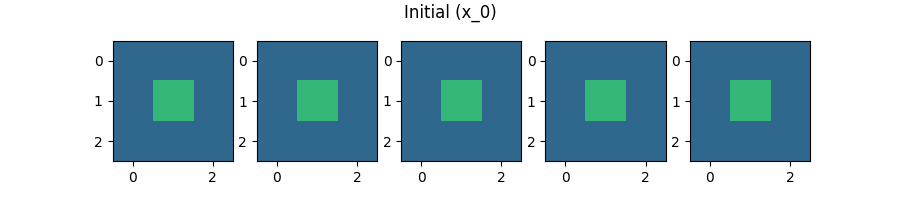

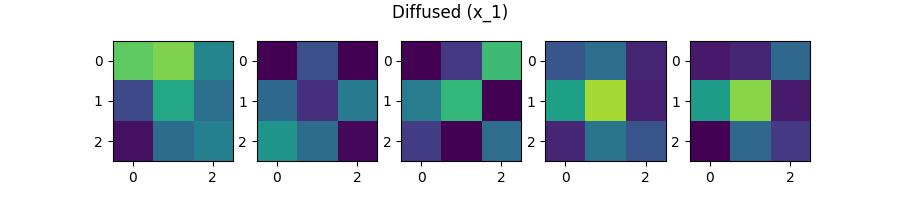

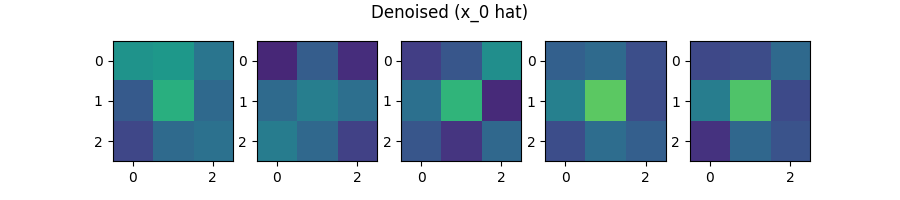

In [22]:
show_plots(batched_reshape(training_data[:num_samples]), True, "Initial (x_0)")
show_plots(batched_reshape(x_init_diffused), True, "Diffused (x_1)")
show_plots(batched_reshape(x_from_diffused), True, "Denoised (x_0 hat)")

In [23]:
# uncomment and run this if there are too many plots open
# "Figure x" at the top of the current figure means there are x plots open;
# the notebook might complain once x >= 20

# for _ in jnp.arange(30):
#     plt.close()

**Compare the states from the forward process and backward process.**
**What do you observe? Note down your observations in the written part of this homework.**

Feel free to also try playing around with different choices of `timesteps`
for generating `x_from_noise` samples after running the denoising generation
process for `timesteps` number of steps.

## Congrats!

You've finished the homework!
(Don't forget to also answer the homework processes and study groups question.)

We hope you've enjoyed learning about diffusion models with us! :D

Have a cat for your troubles:

```
      |\      _,,,---,,_
ZZZzz /,`.-'`'    -.  ;-;;,_
     |,4-  ) )-,_. ,\ (  `'-'
    '---''(_/--'  `-'\_) 
```